In [1]:
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import epfl_campus
from time import time

print('before')

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       ms_radius=60,
#                       ms_between_distance=60)
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       ms_radius=60,
#                       ms_between_distance=60)
params = get_settings(scale_to_mm=1000,
                      hm_detection_threshold=0.05,
                      pp_conflict_overlap=0.4,
                      min_joint_distance=20,
                      gp_max_radius=300,
                      ms_radius=10,
                      ms_between_distance=60)
loader = Loader()
# =====================================

import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)

    
def generate_pcp_score(frame):
    global Settings, params
    alpha = 0.5
    
    Im, Y, Calib = epfl_campus.get(root, frame)
    heatmaps, pafs = loader.load_confidence_map_and_paf(
        'campus', Im, frame, dir=Settings['tmp'])
    detections = pose.estimate(Calib, heatmaps, pafs, 
                               settings=params, debug=False)
    #detections = gen.apply(detections)
    Humans = kth.transform3d_from_mscoco(detections)
    
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    del heatmaps
    del pafs
    del detections
    del Im
    del Y
    del Calib
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs

# =====================================

valid_frames = list(range(350, 470)) + list(range(650, 750))
PER_GTID = {}
FRAMES = []
AVG = []

for frame in valid_frames:
    _start = time()
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs =\
        generate_pcp_score(frame)
    _end = time()
    print('frame ' + str(frame) + ', elapsed:', _end - _start)
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
        ):
            if not gtid in PER_GTID:
                PER_GTID[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID[gtid]['larms'].append(larms)
            PER_GTID[gtid]['uarms'].append(uarms)
            PER_GTID[gtid]['llegs'].append(llegs)
            PER_GTID[gtid]['ulegs'].append(ulegs)
            PER_GTID[gtid]['frame'].append(frame)
            
            FRAMES.append(frame)
            AVG.append((larms + uarms + llegs + ulegs)/4)
            
            

before


/home/tanke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


frame 350, elapsed: 3.8280935287475586
frame 351, elapsed: 3.0615267753601074
frame 352, elapsed: 3.5245957374572754
frame 353, elapsed: 3.7575056552886963
frame 354, elapsed: 2.8994081020355225
frame 355, elapsed: 2.7796437740325928
frame 356, elapsed: 2.3768835067749023
frame 357, elapsed: 2.80239200592041
frame 358, elapsed: 4.260710000991821
frame 359, elapsed: 3.2298429012298584
frame 360, elapsed: 3.402238368988037
frame 361, elapsed: 2.983098030090332
frame 362, elapsed: 2.9059135913848877
frame 363, elapsed: 3.74817156791687
frame 364, elapsed: 3.6753461360931396
frame 365, elapsed: 2.786215305328369
frame 366, elapsed: 2.812493324279785
frame 367, elapsed: 2.839816093444824
frame 368, elapsed: 3.8405838012695312
frame 369, elapsed: 3.494926691055298
frame 370, elapsed: 3.8913302421569824
frame 371, elapsed: 3.9570863246917725
frame 372, elapsed: 3.3118104934692383
frame 373, elapsed: 2.9743921756744385
frame 374, elapsed: 3.0605757236480713
frame 375, elapsed: 2.21597123146057

frame 744, elapsed: 3.4931037425994873
frame 745, elapsed: 3.021494150161743
frame 746, elapsed: 5.3795177936553955
frame 747, elapsed: 5.10783839225769
frame 748, elapsed: 5.5734758377075195
frame 749, elapsed: 4.362731456756592


In [2]:
total_avg = []
for key, values in PER_GTID.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

actor  1
	uarms: 0.9840425531914894
	larms: 0.5877659574468085
	ulegs: 1.0
	llegs: 0.9973404255319149
	avg:   0.8922872340425532
actor  2
	uarms: 0.9522058823529411
	larms: 0.7389705882352942
	ulegs: 0.9889705882352942
	llegs: 0.9889705882352942
	avg:   0.9172794117647058
actor  0
	uarms: 0.7916666666666666
	larms: 0.6041666666666666
	ulegs: 1.0
	llegs: 1.0
	avg:   0.8489583333333333

avg*:   0.8861749930468642


In [3]:
# =====================================
# NO UNARY TERM
# NORMAL LIMB BINARY
# LOG INTRA BINARY
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       ms_radius=60,
#                       ms_between_distance=60)
# NO PC
# actor  1
# 	uarms: 0.9920212765957447
# 	larms: 0.550531914893617
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8856382978723404
# actor  2
# 	uarms: 0.9595588235294118
# 	larms: 0.7463235294117647
# 	ulegs: 0.9963235294117647
# 	llegs: 0.9963235294117647
# 	avg:   0.9246323529411764
# actor  0
# 	uarms: 0.6666666666666666
# 	larms: 0.4583333333333333
# 	ulegs: 0.9791666666666666
# 	llegs: 0.9791666666666666
# 	avg:   0.7708333333333333

# avg*:   0.8603679947156166

# =====================================
# NO UNARY TERM
# NORMAL LIMB BINARY
# SQUARED INTRA BINARY
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       ms_radius=60,
#                       ms_between_distance=60)
# NO PC
# actor  1
# 	uarms: 0.8776595744680851
# 	larms: 0.4308510638297872
# 	ulegs: 0.973404255319149
# 	llegs: 0.9042553191489362
# 	avg:   0.7965425531914894
# actor  2
# 	uarms: 0.8897058823529411
# 	larms: 0.6580882352941176
# 	ulegs: 0.9117647058823529
# 	llegs: 0.8897058823529411
# 	avg:   0.8373161764705882
# actor  0
# 	uarms: 0.6666666666666666
# 	larms: 0.4791666666666667
# 	ulegs: 0.96875
# 	llegs: 0.9791666666666666
# 	avg:   0.7734374999999999

# avg*:   0.8024320765540258

# =====================================
# NO UNARY TERM
# NORMAL LIMB BINARY
# LINEAR INTRA BINARY
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       ms_radius=60,
#                       ms_between_distance=60)

# NO PC
# actor  1
# 	uarms: 0.8776595744680851
# 	larms: 0.4308510638297872
# 	ulegs: 0.973404255319149
# 	llegs: 0.9042553191489362
# 	avg:   0.7965425531914894
# actor  2
# 	uarms: 0.8897058823529411
# 	larms: 0.6580882352941176
# 	ulegs: 0.9117647058823529
# 	llegs: 0.8897058823529411
# 	avg:   0.8373161764705882
# actor  0
# 	uarms: 0.6666666666666666
# 	larms: 0.4791666666666667
# 	ulegs: 0.96875
# 	llegs: 0.9791666666666666
# 	avg:   0.7734374999999999

# avg*:   0.8024320765540258


# =====================================
# NO UNARY TERM
# LINEAR LIMB BINARIES
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       ms_radius=60,
#                       ms_between_distance=60)
# TOO SLOW!


# =====================================
# NO UNARY TERM
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       ms_radius=60,
#                       ms_between_distance=60)
# WITHOUT PC
# actor  1
# 	uarms: 0.9787234042553191
# 	larms: 0.5851063829787234
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8902925531914894
# actor  2
# 	uarms: 0.9522058823529411
# 	larms: 0.7426470588235294
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.9181985294117647
# actor  0
# 	uarms: 0.7916666666666666
# 	larms: 0.6041666666666666
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8489583333333333

# avg*:   0.8858164719788624

# WITH PC
# actor  1
# 	uarms: 0.9920212765957447
# 	larms: 0.5877659574468085
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.894281914893617
# actor  2
# 	uarms: 0.9669117647058824
# 	larms: 0.7830882352941176
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.9319852941176472
# actor  0
# 	uarms: 0.8020833333333334
# 	larms: 0.6145833333333334
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8541666666666667

# avg*:   0.8934779585593103

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       gp_max_radius=300,
#                       ms_radius=240,
#                       ms_between_distance=60)
# WITH PC
# actor  1
# 	uarms: 0.973404255319149
# 	larms: 0.6223404255319149
# 	ulegs: 0.9920212765957447
# 	llegs: 0.9920212765957447
# 	avg:   0.8949468085106383
# actor  2
# 	uarms: 0.9779411764705882
# 	larms: 0.7977941176470589
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.9439338235294118
# actor  0
# 	uarms: 0.7604166666666666
# 	larms: 0.5729166666666666
# 	ulegs: 0.9791666666666666
# 	llegs: 0.9791666666666666
# 	avg:   0.8229166666666666

# avg*:   0.8872657662355722

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       gp_max_radius=300,
#                       ms_radius=10,
#                       ms_between_distance=60)
# WITH PC
# actor  1
# 	uarms: 0.9973404255319149
# 	larms: 0.5957446808510638
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8976063829787234
# actor  2
# 	uarms: 0.9705882352941176
# 	larms: 0.7794117647058824
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.9319852941176472
# actor  0
# 	uarms: 0.8229166666666666
# 	larms: 0.625
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8619791666666666

# avg*:   0.8971902812543457


# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       gp_max_radius=130,
#                       ms_radius=60,
#                       ms_between_distance=60)
# params = get_settings(
#     hm_detection_threshold=0.05,
#     scale_to_mm=1000,
#     ms_radius=30,
#     ms_between_distance=100,
#     gp_max_radius=130,
#     pp_conflict_overlap=0.5
# )
# actor  1
# 	uarms: 0.973404255319149
# 	larms: 0.5638297872340425
# 	ulegs: 0.9893617021276596
# 	llegs: 0.9707446808510638
# 	avg:   0.8743351063829787
# actor  2
# 	uarms: 0.9669117647058824
# 	larms: 0.7426470588235294
# 	ulegs: 0.9375
# 	llegs: 0.9338235294117647
# 	avg:   0.8952205882352942
# actor  0
# 	uarms: 0.78125
# 	larms: 0.6145833333333334
# 	ulegs: 0.84375
# 	llegs: 0.90625
# 	avg:   0.7864583333333334

# avg*:   0.8520046759838688

# =====================================
# params = get_settings(
#     hm_detection_threshold=0.05,
#     scale_to_mm=1000,
#     ms_radius=30,
#     ms_between_distance=100,
#     gp_max_radius=130,
#     pp_conflict_overlap=0.5
# )
# actor  1
# 	uarms: 0.9654255319148937
# 	larms: 0.5771276595744681
# 	ulegs: 0.9840425531914894
# 	llegs: 0.9335106382978723
# 	avg:   0.8650265957446809
# actor  2
# 	uarms: 0.9301470588235294
# 	larms: 0.7169117647058824
# 	ulegs: 0.9338235294117647
# 	llegs: 0.9338235294117647
# 	avg:   0.8786764705882353
# actor  0
# 	uarms: 0.65625
# 	larms: 0.5104166666666666
# 	ulegs: 0.9479166666666666
# 	llegs: 0.9375
# 	avg:   0.7630208333333333

# avg*:   0.835574633222083

# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=30,
#     ms_between_distance=100,
#     gp_max_radius=130,
#     pp_conflict_overlap=0.5
# )
# actor  1
# 	uarms: 0.9654255319148937
# 	larms: 0.5904255319148937
# 	ulegs: 0.9840425531914894
# 	llegs: 0.9335106382978723
# 	avg:   0.8683510638297873
# actor  2
# 	uarms: 0.8676470588235294
# 	larms: 0.6360294117647058
# 	ulegs: 0.9411764705882353
# 	llegs: 0.9375
# 	avg:   0.8455882352941176
# actor  0
# 	uarms: 0.5520833333333334
# 	larms: 0.4479166666666667
# 	ulegs: 0.8958333333333334
# 	llegs: 0.8958333333333334
# 	avg:   0.6979166666666667

# avg*:   0.8039519885968573

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       min_joint_distance=20,
#                       ms_radius=60,
#                       ms_between_distance=60)
# OHNE PC
# actor  1
# 	uarms: 0.9787234042553191
# 	larms: 0.5904255319148937
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8916223404255319
# actor  2
# 	uarms: 0.9558823529411765
# 	larms: 0.7279411764705882
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.9154411764705883
# actor  0
# 	uarms: 0.8125
# 	larms: 0.6145833333333334
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8567708333333334

# avg*:   0.8879447834098179

# MIT PC
#actor  1
# 	uarms: 0.9920212765957447
# 	larms: 0.5930851063829787
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8956117021276596
# actor  2
# 	uarms: 0.9705882352941176
# 	larms: 0.7830882352941176
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.9329044117647058
# actor  0
# 	uarms: 0.8229166666666666
# 	larms: 0.625
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8619791666666666

# avg*:   0.8968317601863439

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.03,
#                       pp_conflict_overlap=0.7,
#                       ms_radius=60,
#                       ms_between_distance=60)
# OHNE PC
# actor  1
# 	uarms: 0.9680851063829787
# 	larms: 0.5904255319148937
# 	ulegs: 0.9840425531914894
# 	llegs: 0.9813829787234043
# 	avg:   0.8809840425531916
# actor  2
# 	uarms: 0.9558823529411765
# 	larms: 0.75
# 	ulegs: 0.9926470588235294
# 	llegs: 0.9926470588235294
# 	avg:   0.9227941176470589
# actor  0
# 	uarms: 0.7604166666666666
# 	larms: 0.5729166666666666
# 	ulegs: 0.9166666666666666
# 	llegs: 0.9166666666666666
# 	avg:   0.7916666666666666

# avg*:   0.8651482756223058

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.03,
#                       pp_conflict_overlap=0.6,
#                       ms_radius=60,
#                       ms_between_distance=60)
# OHNE PC
# actor  1
# 	uarms: 0.9787234042553191
# 	larms: 0.5930851063829787
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8922872340425532
# actor  2
# 	uarms: 0.9632352941176471
# 	larms: 0.7573529411764706
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.9301470588235294
# actor  0
# 	uarms: 0.7916666666666666
# 	larms: 0.5833333333333334
# 	ulegs: 0.9583333333333334
# 	llegs: 0.9583333333333334
# 	avg:   0.8229166666666667

# avg*:   0.8817836531775831

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.03,
#                       pp_conflict_overlap=0.2,
#                       ms_radius=60,
#                       ms_between_distance=60)
# OHNE PC
# actor  1
# 	uarms: 0.973404255319149
# 	larms: 0.5904255319148937
# 	ulegs: 0.9946808510638298
# 	llegs: 0.9920212765957447
# 	avg:   0.8876329787234043
# actor  2
# 	uarms: 0.9558823529411765
# 	larms: 0.7536764705882353
# 	ulegs: 0.9926470588235294
# 	llegs: 0.9926470588235294
# 	avg:   0.9237132352941176
# actor  0
# 	uarms: 0.8020833333333334
# 	larms: 0.5729166666666666
# 	ulegs: 0.9583333333333334
# 	llegs: 0.9583333333333334
# 	avg:   0.8229166666666667

# avg*:   0.8780876268947294

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.03,
#                       pp_conflict_overlap=0.4,
#                       ms_radius=60,
#                       ms_between_distance=60)

# OHNE PC
# actor  1
# 	uarms: 0.9787234042553191
# 	larms: 0.5930851063829787
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8922872340425532
# actor  2
# 	uarms: 0.9632352941176471
# 	larms: 0.7573529411764706
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.9301470588235294
# actor  0
# 	uarms: 0.8020833333333334
# 	larms: 0.5729166666666666
# 	ulegs: 0.9791666666666666
# 	llegs: 0.9791666666666666
# 	avg:   0.8333333333333333

# avg*:   0.8852558753998053

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       ms_radius=60,
#                       ms_between_distance=60)

# OHNE PC
# actor  1
# 	uarms: 0.976063829787234
# 	larms: 0.5824468085106383
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8889627659574468
# actor  2
# 	uarms: 0.9669117647058824
# 	larms: 0.7426470588235294
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.921875
# actor  0
# 	uarms: 0.8125
# 	larms: 0.5833333333333334
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8489583333333334

# avg*:   0.8865986997635934

# MIT PC
# actor  1
# 	uarms: 0.9893617021276596
# 	larms: 0.5851063829787234
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8929521276595744
# actor  2
# 	uarms: 0.9779411764705882
# 	larms: 0.8051470588235294
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.9402573529411766
# actor  0
# 	uarms: 0.8229166666666666
# 	larms: 0.59375
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8541666666666666

# avg*:   0.8957920490891392


# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       ms_radius=90,
#                       ms_between_distance=70)
# MIT PC
# actor  1
# 	uarms: 0.9813829787234043
# 	larms: 0.5904255319148937
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8922872340425532
# actor  2
# 	uarms: 0.9742647058823529
# 	larms: 0.7977941176470589
# 	ulegs: 0.9816176470588235
# 	llegs: 0.9816176470588235
# 	avg:   0.9338235294117646
# actor  0
# 	uarms: 0.7916666666666666
# 	larms: 0.59375
# 	ulegs: 0.9791666666666666
# 	llegs: 0.9791666666666666
# 	avg:   0.8359374999999999

# avg*:   0.8873494211514393

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       ms_radius=40,
#                       ms_between_distance=70)
# MIT PC
# actor  1
# 	uarms: 0.9946808510638298
# 	larms: 0.5877659574468085
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8949468085106382
# actor  2
# 	uarms: 0.9742647058823529
# 	larms: 0.7977941176470589
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.9375
# actor  0
# 	uarms: 0.8229166666666666
# 	larms: 0.59375
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8541666666666666

# avg*:   0.8955378250591016

# =====================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       ms_radius=70,
#                       ms_between_distance=40)
# # MIT PC
# actor  1
# 	uarms: 0.9893617021276596
# 	larms: 0.5851063829787234
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8929521276595744
# actor  2
# 	uarms: 0.9742647058823529
# 	larms: 0.8014705882352942
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.9384191176470589
# actor  0
# 	uarms: 0.8229166666666666
# 	larms: 0.6041666666666666
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8567708333333333

# avg*:   0.8960473595466555


# =============================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       ms_radius=90,
#                       ms_between_distance=40)
# MIT PC
# actor  1
# 	uarms: 0.9813829787234043
# 	larms: 0.5877659574468085
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8916223404255319
# actor  2
# 	uarms: 0.9742647058823529
# 	larms: 0.7977941176470589
# 	ulegs: 0.9816176470588235
# 	llegs: 0.9816176470588235
# 	avg:   0.9338235294117646
# actor  0
# 	uarms: 0.7916666666666666
# 	larms: 0.59375
# 	ulegs: 0.9791666666666666
# 	llegs: 0.9791666666666666
# 	avg:   0.8359374999999999

# avg*:   0.8871277899457656

# =============================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       ms_radius=40,
#                       ms_between_distance=90)

# MIT PC
# actor  1
# 	uarms: 0.9813829787234043
# 	larms: 0.5851063829787234
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8909574468085106
# actor  2
# 	uarms: 0.9742647058823529
# 	larms: 0.7941176470588235
# 	ulegs: 0.9816176470588235
# 	llegs: 0.9816176470588235
# 	avg:   0.9329044117647058
# actor  0
# 	uarms: 0.8125
# 	larms: 0.5833333333333334
# 	ulegs: 0.9791666666666666
# 	llegs: 0.9791666666666666
# 	avg:   0.8385416666666666

# avg*:   0.8874678417466276
    
# ==============================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       ms_radius=80,
#                       ms_between_distance=80)
# MIT PC
# actor  1
# 	uarms: 0.9813829787234043
# 	larms: 0.5824468085106383
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8902925531914894
# actor  2
# 	uarms: 0.9742647058823529
# 	larms: 0.8088235294117647
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.9402573529411766
# actor  0
# 	uarms: 0.8229166666666666
# 	larms: 0.6145833333333334
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.859375

# avg*:   0.8966416353775554

# ==============================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       ms_radius=70,
#                       ms_between_distance=70)
# MIT PC
#actor  1
# 	uarms: 0.9893617021276596
# 	larms: 0.5851063829787234
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8929521276595744
# actor  2
# 	uarms: 0.9742647058823529
# 	larms: 0.8014705882352942
# 	ulegs: 0.9889705882352942
# 	llegs: 0.9889705882352942
# 	avg:   0.9384191176470589
# actor  0
# 	uarms: 0.8229166666666666
# 	larms: 0.59375
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8541666666666666

# avg*:   0.8951793039911

# =============================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.4,
#                       ms_radius=30,
#                       ms_between_distance=30)

# MIT PC
# actor  1
# 	uarms: 0.9920212765957447
# 	larms: 0.5824468085106383
# 	ulegs: 0.9946808510638298
# 	llegs: 0.9893617021276596
# 	avg:   0.8896276595744681
# actor  2
# 	uarms: 0.9595588235294118
# 	larms: 0.7830882352941176
# 	ulegs: 0.9852941176470589
# 	llegs: 0.9852941176470589
# 	avg:   0.9283088235294118
# actor  0
# 	uarms: 0.8125
# 	larms: 0.6041666666666666
# 	ulegs: 0.9791666666666666
# 	llegs: 0.9791666666666666
# 	avg:   0.8437499999999999

# avg*:   0.8872288277012933

# ==============================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.6,
#                       ms_radius=50,
#                       ms_between_distance=50)
# OHNE PC
# actor  1
# 	uarms: 0.9787234042553191
# 	larms: 0.5797872340425532
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8889627659574468
# actor  2
# 	uarms: 0.9595588235294118
# 	larms: 0.7389705882352942
# 	ulegs: 0.9926470588235294
# 	llegs: 0.9926470588235294
# 	avg:   0.9209558823529412
# actor  0
# 	uarms: 0.8229166666666666
# 	larms: 0.5729166666666666
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8489583333333333

# avg*:   0.8862923272145737

# MIT PC
# actor  1
# 	uarms: 0.9893617021276596
# 	larms: 0.5824468085106383
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8922872340425532
# actor  2
# 	uarms: 0.9669117647058824
# 	larms: 0.7941176470588235
# 	ulegs: 0.9926470588235294
# 	llegs: 0.9926470588235294
# 	avg:   0.9365808823529412
# actor  0
# 	uarms: 0.8333333333333334
# 	larms: 0.59375
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8567708333333334

# avg*:   0.8952129832429426


# ==============================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       pp_conflict_overlap=0.8,
#                       ms_radius=50,
#                       ms_between_distance=50)
# actor  1
# 	uarms: 0.9680851063829787
# 	larms: 0.574468085106383
# 	ulegs: 0.9893617021276596
# 	llegs: 0.9867021276595744
# 	avg:   0.8796542553191489
# actor  2
# 	uarms: 0.9595588235294118
# 	larms: 0.7389705882352942
# 	ulegs: 0.9926470588235294
# 	llegs: 0.9926470588235294
# 	avg:   0.9209558823529412
# actor  0
# 	uarms: 0.8020833333333334
# 	larms: 0.5520833333333334
# 	ulegs: 0.9791666666666666
# 	llegs: 0.9791666666666666
# 	avg:   0.828125

# avg*:   0.8762450458906966


# ==============================================
# params = get_settings(scale_to_mm=1000,
#                       hm_detection_threshold=0.05,
#                       ms_radius=50,
#                       ms_between_distance=50)

# OHNE PC
# actor  1
# 	uarms: 0.9787234042553191
# 	larms: 0.5797872340425532
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8889627659574468
# actor  2
# 	uarms: 0.9595588235294118
# 	larms: 0.7389705882352942
# 	ulegs: 0.9926470588235294
# 	llegs: 0.9926470588235294
# 	avg:   0.9209558823529412
# actor  0
# 	uarms: 0.8229166666666666
# 	larms: 0.5729166666666666
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8489583333333333

# avg*:   0.8862923272145737


# ==============================================
# params = get_settings(scale_to_mm=1000,
#                       ms_radius=50,
#                       ms_between_distance=50)


# OHNE PC
# actor  1
# 	uarms: 0.9840425531914894
# 	larms: 0.5930851063829787
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8936170212765957
# actor  2
# 	uarms: 0.9117647058823529
# 	larms: 0.6544117647058824
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8915441176470589
# actor  0
# 	uarms: 0.75
# 	larms: 0.5416666666666666
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.8229166666666666

# avg*:   0.8693592685301071

# MIT PC
# actor  1
# 	uarms: 0.9973404255319149
# 	larms: 0.601063829787234
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.898936170212766
# actor  2
# 	uarms: 0.9779411764705882
# 	larms: 0.8125
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.9476102941176471
# actor  0
# 	uarms: 0.7708333333333334
# 	larms: 0.5416666666666666
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.828125

# avg*:   0.8915571547768044

# ==============================================

# standard settings
# MIT PC
# actor  1
# 	uarms: 0.9920212765957447
# 	larms: 0.6090425531914894
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8996010638297872
# actor  2
# 	uarms: 0.9779411764705882
# 	larms: 0.8272058823529411
# 	ulegs: 0.9742647058823529
# 	llegs: 0.9742647058823529
# 	avg:   0.9384191176470588
# actor  0
# 	uarms: 0.71875
# 	larms: 0.5104166666666666
# 	ulegs: 0.9375
# 	llegs: 0.9375
# 	avg:   0.7760416666666666

# avg*:   0.871353949381171

# OHNE PC
# actor  1
# 	uarms: 0.9813829787234043
# 	larms: 0.601063829787234
# 	ulegs: 1.0
# 	llegs: 0.9973404255319149
# 	avg:   0.8949468085106383
# actor  2
# 	uarms: 0.9080882352941176
# 	larms: 0.6617647058823529
# 	ulegs: 0.9742647058823529
# 	llegs: 0.9742647058823529
# 	avg:   0.879595588235294
# actor  0
# 	uarms: 0.6770833333333334
# 	larms: 0.5104166666666666
# 	ulegs: 0.9375
# 	llegs: 0.9375
# 	avg:   0.765625

# avg*:   0.8467224655819775

avg:	 0.625
frame:	 684


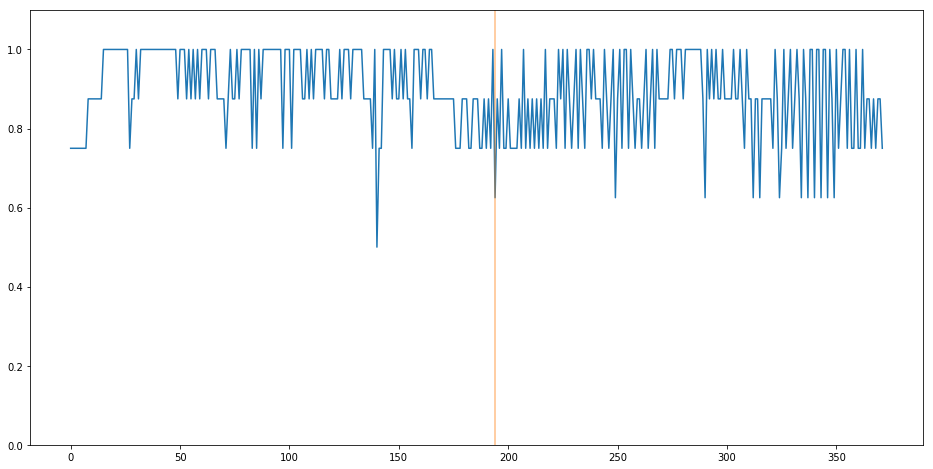

In [4]:
idx = 194

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.plot(range(len(AVG)), AVG)
ax.set_ylim([0, 1.1])

ax.plot([idx, idx], [0, 1.5], alpha=0.5)
 
print("avg:\t", AVG[idx])
print('frame:\t', FRAMES[idx])
FRAME = FRAMES[idx]

plt.show()

step 1: elapsed 0.17188215255737305
step 2: elapsed 0.005609750747680664
step 3: elapsed 0.02996230125427246
step 4: elapsed 0.18538641929626465
-------------------------------------------
Handle transitivity:
	Intra:		 14
	Intra(choice):	 7
	Inter:		 260
	Inter(choice):	 224
-------------------------------------------
	Time =  265  ms
	result: 0

	Total cost: 327.3270914335262

# valid points:		 151
# invalid points:	 15
step 5: elapsed 0.2729377746582031
(smart candidate selection) [
	Time =  10  ms
	result: 0

	Total cost: 6.0374811397840755
] (smart candidate selection)
step 6: elapsed 0.04604744911193848

# detections 2
------
gtid: 1
	larms: 0
	uarms: 1.0
	llegs: 0.5
	ulegs: 1.0
gtid: 2
	larms: 0.5
	uarms: 1.0
	llegs: 1.0
	ulegs: 1.0
avg: 0.75


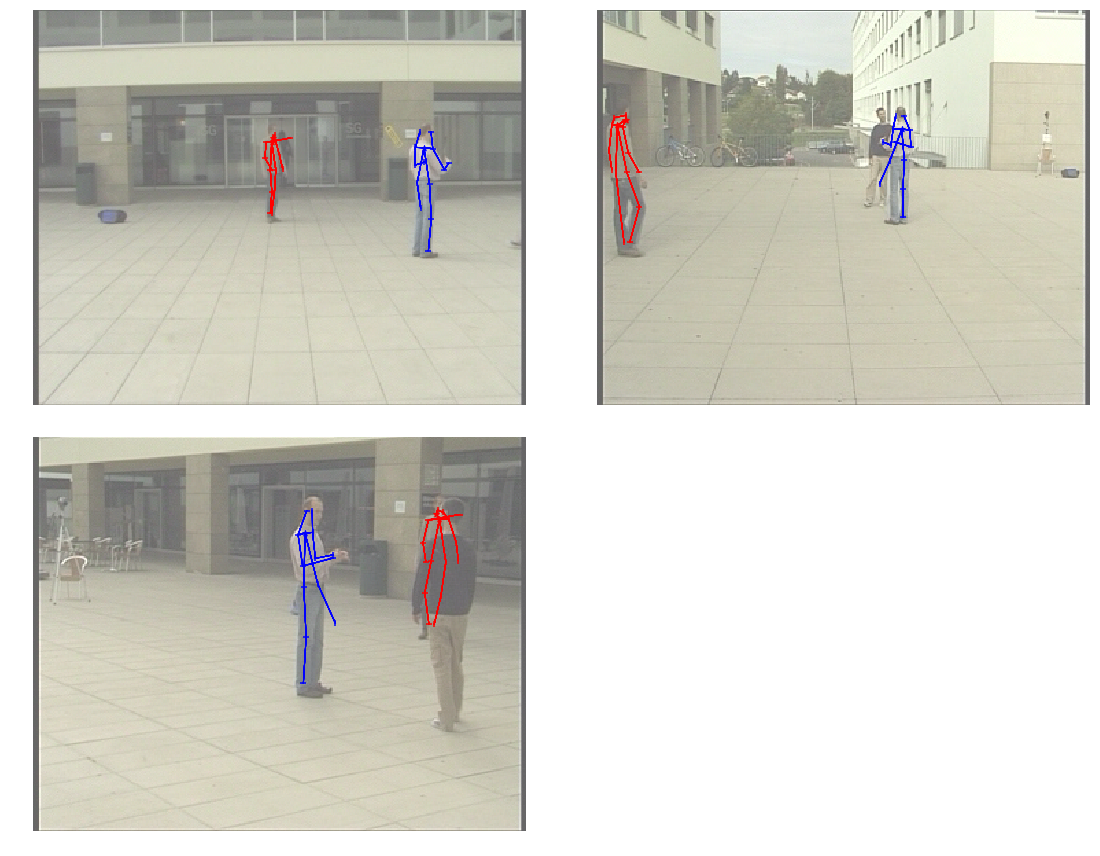

In [5]:
COLORS = ['red', 'green', 'blue', 'yellow']

# ==================================
from mvpose import pose
from mvpose.settings import get_settings
import paf_loader
from mvpose.plot.limbs import draw_mscoco_human

Im, Y, Calib = epfl_campus.get(root, FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('campus', 
                                                        Im, 
                                                        FRAME, 
                                                        dir=tmp)


def get_pcp(detections, Y):
    alpha = 0.5
    Humans = kth.transform3d_from_mscoco(detections)

    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []

    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs



#param = get_settings(scale_to_mm=1000)
param = get_settings(
    scale_to_mm=1000,
    ms_radius=50,
    ms_between_distance=50,
    hm_detection_threshold=0.05
)

Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=param,
                                  debug=True)

print('\n# detections', len(detections))

#detections = gen.apply(detections)


L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = get_pcp(detections, Y)

print('------')
for larms, uarms, llegs, ulegs, gtid in zip(L_Arms, U_Arms, L_Legs, U_Legs, GTIDs):
    print('gtid:', gtid)
    print('\tlarms:', larms)
    print('\tuarms:', uarms)
    print('\tllegs:', llegs)
    print('\tulegs:', ulegs)
    

avg = np.mean(L_Arms) + np.mean(U_Arms) + np.mean(L_Legs) + np.mean(U_Legs)
print('avg:', avg/4)

Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['blue', 'red', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2, 2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
        
plt.tight_layout()
plt.show()